In [12]:

from pylab import *
from scipy.ndimage import filters
import os
def imrow(*args,**kw):
    gray()
    size = kw.get("s",6)
    inter = kw.get("i","nearest")
    if "s" in kw: del kw["s"]
    if "i" in kw: del kw["i"]
    n = len(args)
    subplots(1,n,figsize=(n*size,size))
    for i,im in enumerate(args):
        subplot(1,n,i+1); imshow(im,origin='upper',interpolation=inter,**kw)
def rgb(r,g,b=None):
    if b is None: b = zeros(g.shape)
    return transpose(array([r,g,b]),[1,2,0])
def N(a): return a/max(amax(a),abs(amin(a)))

Template Matching
=================

Let's start with a seemingly simple problem: finding a letter on a page.
We assume that we have a template for the letter, and an image in which
the letter is at exactly the same scale, and in which it is present
in exactly the same font.

(29, 29)


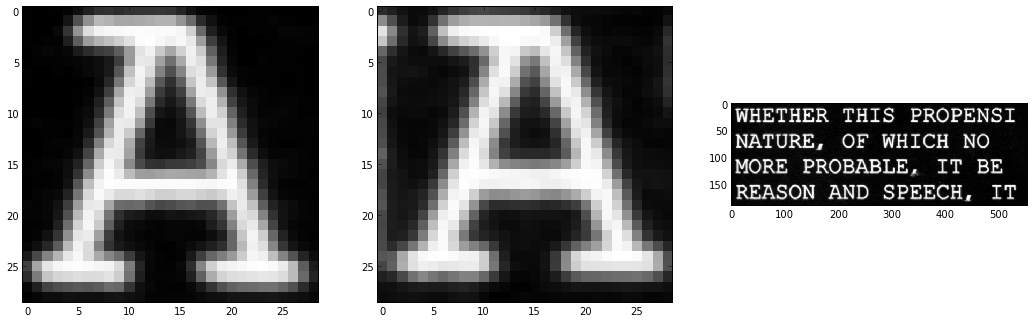

In [5]:
template_A = mean(imread("simple-ocr/template-A.png"),axis=2)
textimage = mean(imread("simple-ocr/small1.png"),axis=2)
print template_A.shape
imrow(template_A,textimage[58:87,30:59],textimage)

A simple idea for finding the letter in the image is the following.
We slide a window across the image that is the size of the letter.
Within the window, we compute the squared (or absolute) difference
between the letter templat and the image.
The letter is present wherever that distance is small.
To visualize that better, we can also display the inverse
distance image and

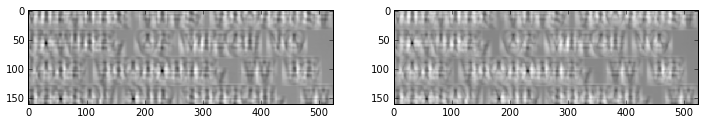

In [18]:
tw,th = template_A.shape
w,h = textimage.shape
ds = zeros((w-tw,h-th))
dw,dh = ds.shape
da = zeros((dw,dh))
for i in range(0,dw):
    for j in range(0,dh):
        ds[i,j] = sum((template_A-textimage[i:i+tw,j:j+th])**2)
        da[i,j] = sum(abs(template_A-textimage[i:i+tw,j:j+th]))
imrow(ds,da)

It's a little easier to see what's going on in the negative image.



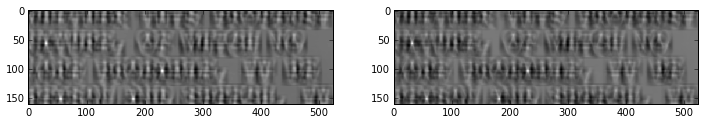

In [19]:
imrow(-ds,-da)

Because the minimum distances aren't easy to identify, let's display this in a different way.

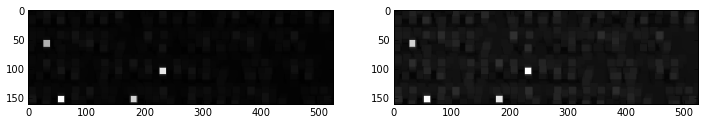

In [20]:
max1 = filters.maximum_filter(1.0/(5.0+ds),(10,10))
max2 = filters.maximum_filter(1.0/(5.0+da),(10,10))
imrow(max1,max2)

Statistically, it's more important to look at the distribution of distances.

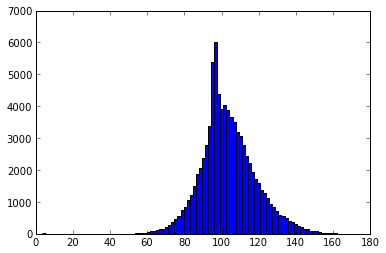

In [21]:
_=hist(ds.ravel(),bins=100)

From this, we can read off that a threshold of 60 might be pretty good for finding
the locations of these letters.



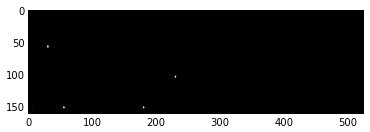

In [22]:
imrow(60-clip(ds,0,60))

Another way of automatically characterizing a distribution like this is by
mean and variance.



In [41]:
mean(ds),sqrt(var(ds))

(103.4008935505834, 14.741544406032297)

Outliers in are pixel values that are "far from" the mean,
where "far" is defined in terms of the variance.
(Like "IQ")

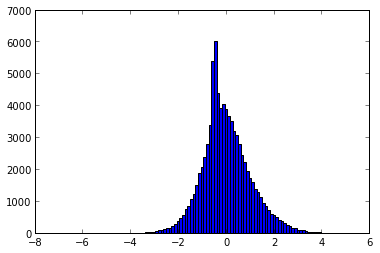

In [73]:
_=hist(((ds-mean(ds))/sqrt(var(ds))).ravel(),bins=100)

It is much easier to pick thresholds and compare the results of different template matches
in this kind of normalized histogram.

Computation via Convolution
===========================

It turns out that the entire operation above can be expressed in terms
of the convolution.  

Consider the distance computation and expand the square:

$d_{ij}^2 = \sum (t_{uv} - I_{i+u,j+v})^2$
$ = \sum t_{uv}^2 - 2 \sum t_{uv} I_{i+u,j+v} + I_{i+u,j+v}^2 $

Now it is easy to see that the individual terms can be written as
follows:

$ d = ||t||^2 - 2 I * \hat{t} + I * b $

Here, $\hat{t}$ is the flipped version of the template $t$, and
$b$ is a box of the same size as the template.

The operation $I * \hat{t}$ is called the *cross correlation* between
the template $t$ and the image $I$.

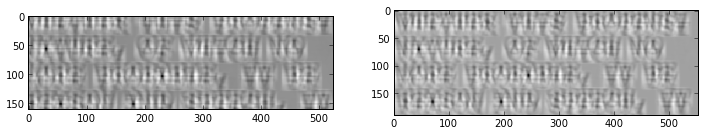

In [27]:
t2 = sum(template_A**2)
cc = filters.convolve(textimage,template_A[::-1,::-1])
I2 = filters.convolve(textimage,ones(template_A.shape))
out = t2-2*cc+I2
imrow(ds,out)

As you can see, up to boundary conditions, the results are the same.

Writing the template matching operation in terms of the convolution lets
us apply all the computational tricks (in particular, the Fourier transform)
to this problem.

(cross correlation for template matching)

Many people use cross correlation as if it were a "template matcher"
all by itself.  It really is not.  

Cross correlation for detection of signals usually assumes zero signals 
and templates with an (expected) zero mean.  

In that case, $||t||^2$ and $I*b$ are expected to be close
to zero.  If you really know that that is the case for your signals, then
you don't have to bother computing $||t||^2$ and $I*b$.  

But usually, computing all terms is a better choice.

Normalized Cross Correlation
=========

Above, we derived template matching and related it to the convolution (and cross correlation)
by considering the Euclidean distance between a template and the image.

There is a second way in which we often determine whether two vectors are similar:
we determine whether they are colinear, or, more generally, what the angle between
them is.  This is done easily by the dot product:

$\cos(\angle(u,v)) = \frac{1}{||u||} u \cdot\frac{1}{||v||} v $

As before, we compute the norm of the template directly, but
we compute the norm of all the image patches by convolution,
and the dot product between the template and the image by
convolution as well.

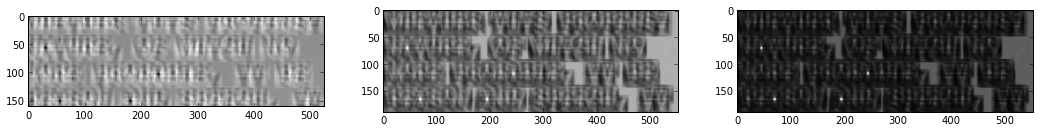

In [28]:
tl = sqrt(sum(template_A**2))
cc = filters.convolve(textimage,template_A[::-1,::-1])
Il = sqrt(filters.convolve(textimage**2,ones(template_A.shape)))
cout = cc/maximum(1e-5,tl*Il)
imrow(ds,cout,cout**8)

Now, there is one more improvement we can make to this.
As written above, if we replace $u$ by $u+w$ and $v$ by $v+w$ for
$w>>u$ and $w>>v$, then the new vectors will be nearly colinear no
matter what $u$ and $v$ are.  

For cross correlation to work well
in detecting a pattern, we want $u$ and $v$ to have a wide variety
of directions, and to accomplish that, we subtract their means.

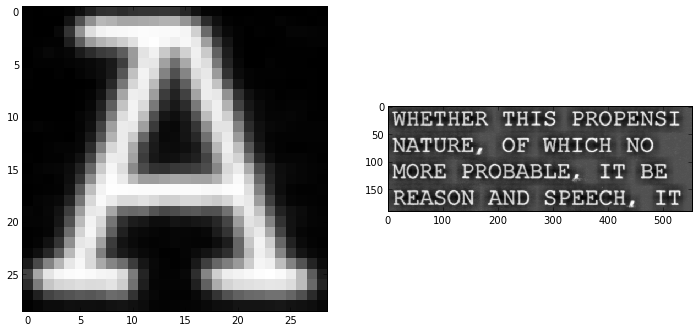

In [29]:
template_A_centered = template_A-mean(template_A)
textimage_centered = textimage-filters.convolve(textimage,ones(template_A.shape)/sum(ones(template_A.shape)))
imrow(template_A_centered,textimage_centered)

-0.457507 0.950109


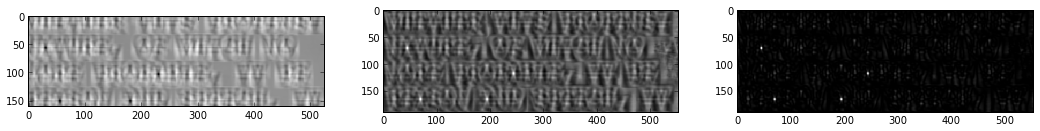

In [31]:
tl = sqrt(sum(template_A_centered**2))
cc = filters.convolve(textimage_centered,template_A_centered[::-1,::-1])
Il = sqrt(filters.convolve(textimage_centered**2,ones(template_A_centered.shape)))
cout = cc/maximum(1.0,tl*Il)
imrow(ds,cout,cout**2)
print amin(cout),amax(cout)

There is actually yet another way in which we can express this.
Instead of computing the cross correlation in one step like above, we can
think of this as "standardizing" the image, filtering it with a nonlinear
filter that achieves a constant mean and variance across the image.


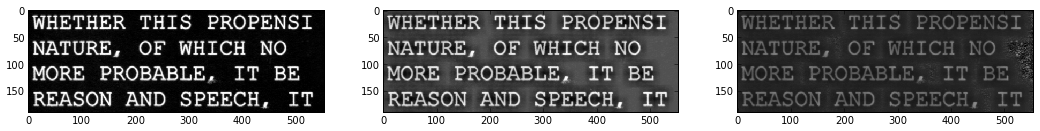

In [32]:
textimage_standardized = textimage_centered/maximum(1e-5,Il)
imrow(textimage,textimage_centered,textimage_standardized)

We can do the same to the template, but of course 
its display doesn't change (since this amounts to just a linear transformation 
of the gray values, which the display routines compensate for).


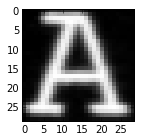

In [33]:
template_A_standardized = template_A_centered / sqrt(sum(template_A_centered**2))
imrow(template_A_standardized,s=2)

In terms of these standardized images, the normalized cross correlation now just requires a convolution with a flipped template.


In [34]:
normalized_cross_correlation = filters.convolve(textimage_standardized,template_A_standardized[::-1,::-1])

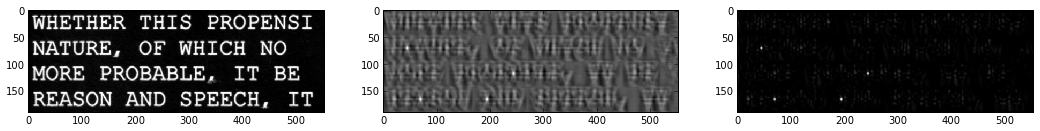

In [35]:
imrow(textimage,normalized_cross_correlation,normalized_cross_correlation**2)

# Peak Finding

Many computer vision algorithms involve the following steps:

- remove noise
- measure similarity to some template
- find a small number of locations where the template is present

We find locations by identifying places of maximum similarity to the template.

Issues in peak finding:

- scores near an actual instance are also high
- global maximum gives us only one location when there may be multiple instances
- local maxima may give us locations with low absolute score
- noise produces false maxima
- we often don't know what the threshold for a good score should be

In [36]:
ncc = normalized_cross_correlation

In [37]:
def local_max(image,sigma=1.0):
    image = filters.gaussian_filter(image,sigma)
    return ((image>roll(image,1,axis=0))*
            (image>roll(image,-1,axis=0))*
            (image>roll(image,1,axis=1))*
            (image>roll(image,-1,axis=1)))

Let's start by finding local maxima in the ncc output.  We can display either their locations,
or their locations with their weights.

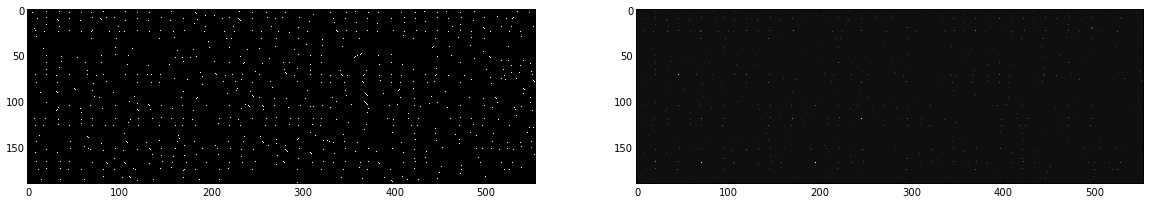

In [242]:
imrow(local_max(ncc),local_max(ncc)*ncc,s=10)

Let's threshold these (since there are too many).  We take, as a threshold, 0.8 of the peak value.

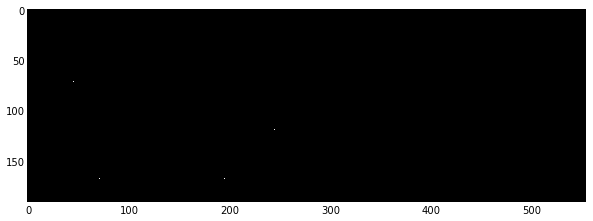

In [250]:
gm = amax(ncc)
lm = local_max(ncc)*ncc*(ncc>0.8*gm)
lm /= amax(lm)
imrow(lm,s=10)

Let's overlay this on the original image, spreading the values around 
as much as the size of the original template.

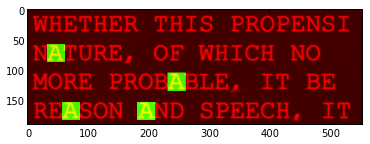

In [251]:
lm30 = filters.maximum_filter(lm,30)
imshow(transpose(array([textimage,lm30,zeros(textimage.shape)]),[1,2,0]))

It is possible that we get multiple peaks per character.
To avoid this, we can use a simple non-linear filtering operation.

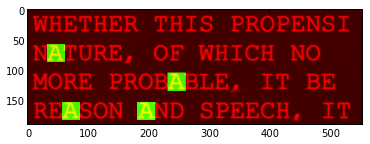

In [247]:
lms = lm*(lm>=filters.maximum_filter(lm,30))
lms30 = filters.maximum_filter(lms,30)
imshow(transpose(array([textimage,lms30,zeros(textimage.shape)]),[1,2,0]))

Less obviously, another good way of getting rid of multiple
peaks is with Gaussian filtering.

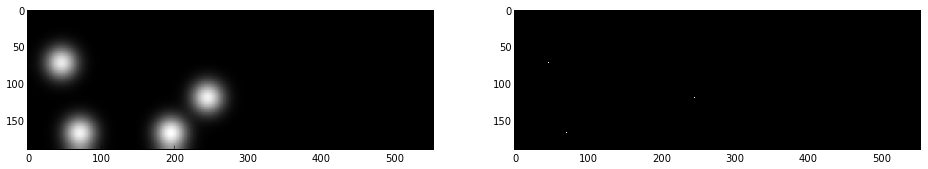

In [239]:
lmg = filters.gaussian_filter(lm,15.0)
lmgs = local_max(lmg)
imrow(lmg,lmgs,s=8)

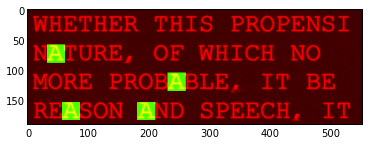

In [201]:
ncclms = where(lm<lm30,0,lm)
lms30 = filters.maximum_filter(lms,30)/amax(lms)
imshow(transpose(array([textimage,lmg30,zeros(textimage.shape)]),[1,2,0]))

Let's see how this works by looking at a bunch of points in well-defined locations,
and seeing them merge for increasingly larger sigma.

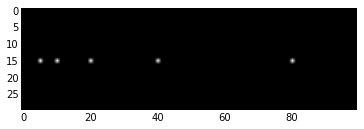

In [213]:
test = zeros((30,100))
test[15,5] = 1
test[15,10] = 1
test[15,20] = 1
test[15,40] = 1
test[15,80] = 1
imshow(test)

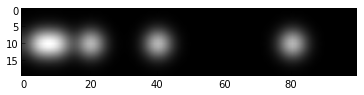

In [206]:
testg = filters.gaussian_filter(test,3.0)
imshow(testg)

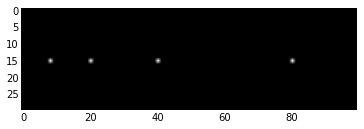

In [223]:
imshow(local_max(filters.gaussian_filter(test,3.0,mode='constant')))

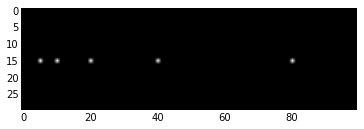

In [222]:
imshow(local_max(filters.gaussian_filter(test,1.0,mode='constant')))

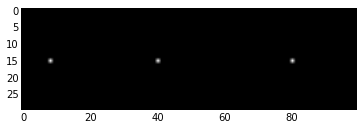

In [221]:
imshow(local_max(filters.gaussian_filter(test,5.0,mode='constant')))

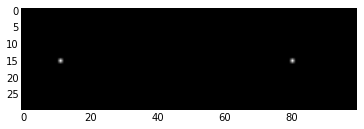

In [220]:
imshow(local_max(filters.gaussian_filter(test,10.0,mode='constant')))

General strategies for peak finding:

- if you don't know a good threshold, use a fraction of the global maximum
- you also should have a conservative absolute threshold
- use local maxima after (and only after) Gaussian smoothing
- Gaussian smoothing will also ensure separation of locations (but make localization less accurate)
- you can complement Gaussian smoothing by inhibiting local maxima close to other local maxima

# Peak Finding with Mathematical Morphology

In [52]:
def showmax(a):
    "just broadens maxima a little with a maximum_filter for better visibility"
    return filters.maximum_filter(a,3)

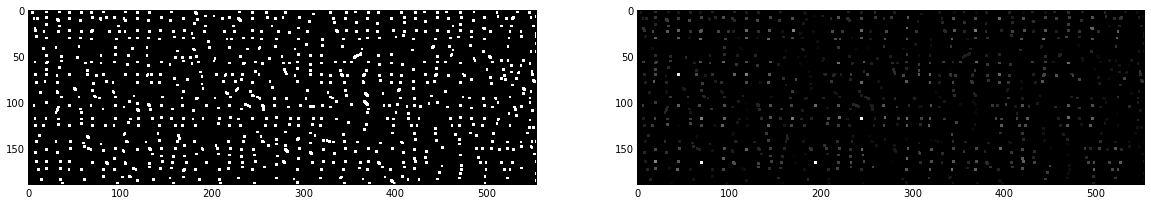

In [53]:
imrow(showmax(local_max(ncc)),showmax(local_max(ncc)*ncc),s=10)

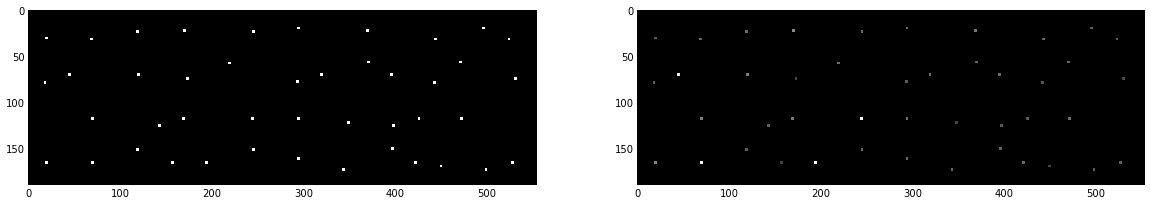

In [54]:
peaks50 = (ncc==filters.maximum_filter(ncc,50))
imrow(showmax(peaks50),showmax(peaks50*ncc),s=10)

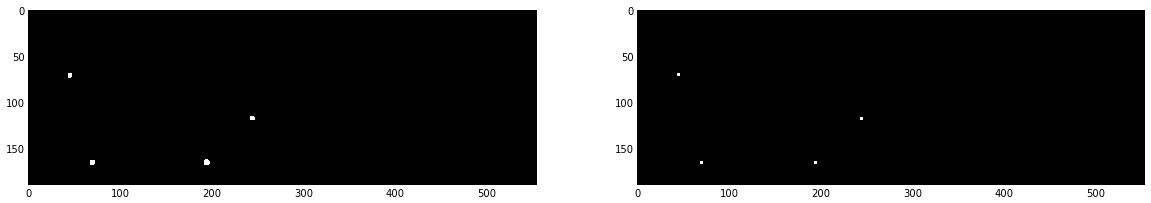

In [55]:
thresh = (ncc>amax(ncc)*0.7)
imrow(showmax(thresh),showmax(peaks50*thresh),s=10)

In [57]:
unravel_index(argmax(ncc),ncc.shape)

(166, 194)

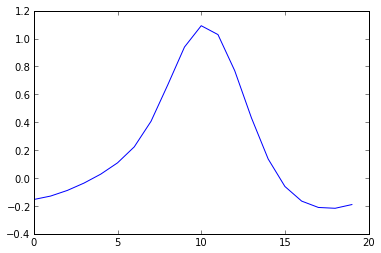

In [64]:
plot(ncc[166,184:204])

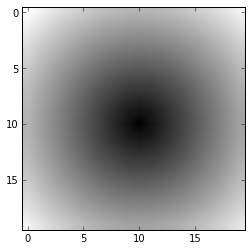

In [63]:
ys,xs = mgrid[-10:10,-10:10]
r = hypot(ys,xs)
imshow(r)

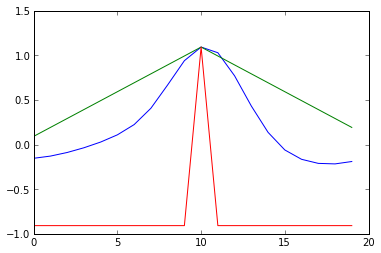

In [72]:
upper = -0.1*r
lower = where(r<1.0,0.0,-2.0)
plot(ncc[166,184:204])
plot(upper[10,:]+ncc[166,194])
plot(lower[10,:]+ncc[166,194])

In [73]:
from scipy.ndimage import morphology

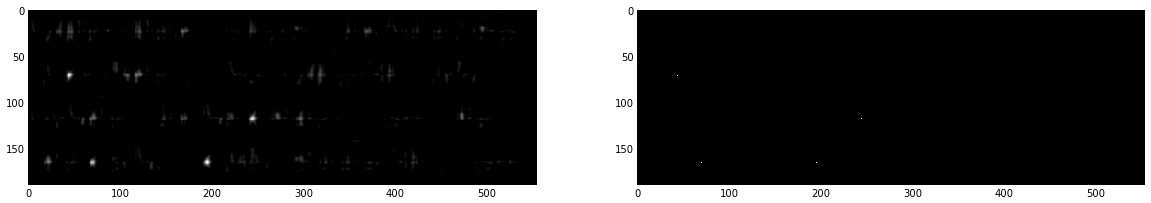

In [76]:
ncc_u = morphology.grey_erosion(ncc,structure=upper)
ncc_l = morphology.grey_dilation(ncc,structure=lower)
mpeaks = -(ncc_u-ncc_l)
mpeaks50 = (mpeaks>0.5*amax(mpeaks))*(mpeaks>=filters.maximum_filter(mpeaks,50))
imrow(mpeaks,mpeaks50,s=10)

(template matching and peak finding)

template matching:

- template matching turns a difficult matching problem into an easier one
- the easier matching problem is peak finding

peak properties:

- peaks usually look roughly Gaussian (why?)
- absolute magnitude
- steepness / localization
- density / separation

detect with:

- Gaussian filtering and local maxima (scale space)
- mathematical morphology (peak templates)